<a href="https://colab.research.google.com/github/Sompote/pile_deep_learning/blob/main/CGANv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import numpy
from numpy import hstack
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras import Input
from keras.layers import Dense,LSTM, Reshape
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
df = pd.read_excel("/content/pile.xlsx", usecols=[0, 1], names=["X", "Y"])

def gen_conditon(n_input,con):
    x_con=np.zeros((1,12,con.shape[0]))
    x_con[0,:,0]=.2
    return x_con


x_data_real = np.array(df.values)
scaler = MinMaxScaler()
x_data_real = scaler.fit_transform(x_data_real)
x_data=np.reshape(x_data_real,(1,x_data_real.shape[0],x_data_real.shape[1]))
#add conditon into array
con=np.array([5]) #add condition to array
con_data=gen_conditon(n_input=1,con=con)
x_data=np.concatenate((x_data, con_data),axis=2)
n=x_data.shape[0]
y_data = np.ones((n, 1))

x_data.shape

(1, 12, 3)

In [9]:
x_data

array([[[0.        , 1.        , 0.2       ],
        [0.08134872, 0.9730664 , 0.2       ],
        [0.22033046, 0.92049546, 0.2       ],
        [0.30372149, 0.90009122, 0.2       ],
        [0.40040747, 0.8576984 , 0.2       ],
        [0.50073473, 0.74828364, 0.2       ],
        [0.58655163, 0.68323011, 0.2       ],
        [0.68083665, 0.57371933, 0.2       ],
        [0.7751117 , 0.49767152, 0.2       ],
        [0.77515654, 0.29646166, 0.2       ],
        [0.88153104, 0.17605262, 0.2       ],
        [1.        , 0.        , 0.2       ]]])

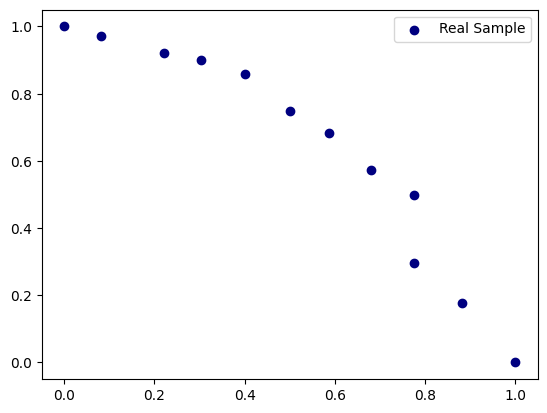

In [11]:
plt.scatter(x_data[0,:,0],x_data[0,:,1],label = 'Real Sample',color='navy')
plt.legend(fontsize=10)
plt.show()

In [ ]:
x_data_real.shape

(12, 2)

In [32]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras import Input
from keras.layers import Dense,LSTM,Concatenate ,Flatten
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model


LENGTH_INPUT_real = x_data.shape[1]
LENGTH_INPUT =x_data.shape[1]

# define the standalone discriminator model
def define_discriminator(n_inputs=LENGTH_INPUT_real):
    model = Sequential()
    model.add(Input(shape=(n_inputs, 3)))
    model.add(LSTM(100))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def define_condion(n_feature,n_output):
    model = Sequential()
    model.add(Input(shape=(n_feature)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_output*n_feature, activation='sigmoid'))
    model.add(Reshape((n_output, 1))) # reshape
    return model

    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# define the standalone generator model
def define_generator(latent_dim, n_outputs=LENGTH_INPUT):
    model = Sequential()
    model.add(Input(shape=(latent_dim, 2)))
    model.add(LSTM(100))
    model.add(Dense(n_outputs*2, activation='linear'))
    model.add(Reshape((n_outputs, 2))) # reshape
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mean_absolute_error'])

    return model
def define_gen_com(model_con, model_gen,n_outputs=12):

    # Connect the generator and discriminator
    modelcon_output = model_con.output
    model_gen_input=model_gen.input
    model_gen_output=model_gen.output

    # Use the functional API to concatenate the conditional data and the generator output
    concatenated = Concatenate()([modelcon_output, model_gen_output])
    discriminator_output = discriminator(concatenated)
    inputs = [generator.input,model_con.input]  # Generator input and conditional data

    # Create the GAN model
    # Use a list to combine the generator input and the conditional data
    inputs = [model_gen_input,model_con.output]  # Generator input and conditional data
    outputs = discriminator_output
    #model part
    concatenated = Concatenate()([modelcon_output, model_gen_output])
    modelc=Dense(50, activation='linear')(concatenated)
    modelc=Flatten()(modelc)
    modelc= Dense(n_outputs*2, activation='linear')(modelc)
    modelc=Reshape((n_outputs, 2))(modelc) # reshape

    model = Model(inputs=inputs, outputs=modelc)
    model.compile(loss='binary_crossentropy', optimizer='adam')
# define the combined generator and discriminator model, for updating the generator


def combind_model(dense_model,cnn_model,y_train):
  combined_input_dense = dense_model.output
  combined_input_cnn = cnn_model.output
  combined_input_LSTM = LSTM_model.output
  combined_input = concatenate([combined_input_cnn,combined_input_dense])
  combined_output = Dense(y_train.shape[1], activation='linear')(combined_input)
  combined_model = Model(inputs=[cnn_model.input,dense_model.input], outputs=combined_output)
  return combined_model

def define_gan(generator, discriminator):
    # Make weights in the discriminator not trainable
    discriminator.trainable = False

    # Connect the generator and discriminator
    generator_output = generator.output
    #con_data = generator.input[1]  # Conditional data input

    # Use the functional API to concatenate the conditional data and the generator output
    concatenated = Concatenate()([con_data, generator_output])
    discriminator_output = discriminator(concatenated)

    # Create the GAN model
    # Use a list to combine the generator input and the conditional data
    inputs = [generator.input]  # Generator input and conditional data
    outputs = discriminator_output
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

# generate n real samples with class labels
def generate_real_samples(n):
    amps = np.arange(0.1,10,0.1)
    bias = np.arange(0.1,10,0.1)
    freqs = np.linspace(1,2,1000)
    X2 = np.linspace(-5,5,LENGTH_INPUT)
    X1 = []
    for x in range(n):
        noise = np.random.normal(size=len(X2))
        X1.append(np.random.choice(amps)*np.sin(X2*np.random.choice(freqs))+np.random.choice(bias)+0.3*noise)
    X1 = np.array(X1).reshape(n, LENGTH_INPUT)
    # generate class labels
    y = ones((n, 1))
    return X1, y
def gen_conditon(n_input,con):
    x_con=np.zeros((1,12,con.shape[0]))
    x_con[0,:,0]=.2

    return x_con
def generate_latent_points_n(latent_dim, n):
    # generate points in the latent space
    x_input1 = randn(latent_dim)
    x_input1=np.reshape(x_input1,(1,latent_dim))
    #x_input = x_input.reshape(n, latent_dim)
    return x_input1

def define_generator_n(latent_dim, n_outputs=LENGTH_INPUT):
    model = Sequential()
    model.add(Input(shape=(latent_dim)))
    model.add(Dense(300, activation='sigmoid'))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(n_outputs*2, activation='linear'))
    model.add(Reshape((n_outputs, 2))) # reshape
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mean_absolute_error'])

    return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input1 = randn(latent_dim * n)
    x_input1 = x_input1.reshape(n, latent_dim)
       # reshape into a batch of inputs for the network
    x_input2=randn(latent_dim * n)
    x_input2 = x_input2.reshape(n, latent_dim)
    x_input=np.zeros((n,latent_dim,2))
    x_input[:,:,0]=x_input1
    x_input[:,:,1]=x_input2

    #x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points_n(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input, verbose=0)
    X=np.concatenate((X, con_data),axis=2)

    # create class labels
    y = zeros((n, 1))
    #print(x_input)
    return X, y


# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=1, n_eval=200):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch/2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        #x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        # update discriminator
        d_model.train_on_batch(x_data, y_data)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points_n(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            plt.title('Number of epochs = %i'%(i+1))
            pred_data = generate_fake_samples(generator,latent_dim,latent_dim)[0]
            #real_data  = generate_real_samples(latent_dim)[0]
            real_data= x_data_real
            plt.plot(pred_data[0,:,0],pred_data[0,:,1],'.',label='Random Fake Sample',color='firebrick')
            plt.scatter(x_data_real[:,0],x_data_real[:,1],label = 'Random Real Sample',color='navy')
            plt.legend(fontsize=10)
            plt.show()
# size of the latent space
latent_dim = 100
#feature
con=np.array([5])
con_data=gen_conditon(n_input=1,con=con)

# create the discriminator
discriminator = define_discriminator()
# create the generator
model_gen=define_generator(latent_dim, n_outputs=LENGTH_INPUT)
model_con=define_condion(n_feature=1,n_output=12)
generator = define_gen_com(model_con, model_gen)

# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

AttributeError: ignored

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_165 (Dense)           (None, 300)               30300     
                                                                 
 dense_166 (Dense)           (None, 100)               30100     
                                                                 
 dense_167 (Dense)           (None, 50)                5050      
                                                                 
 dense_168 (Dense)           (None, 24)                1224      
                                                                 
 reshape_29 (Reshape)        (None, 12, 2)             0         
                                                                 
 concatenate_15 (Concatenate  (1, 12, 3)               0   

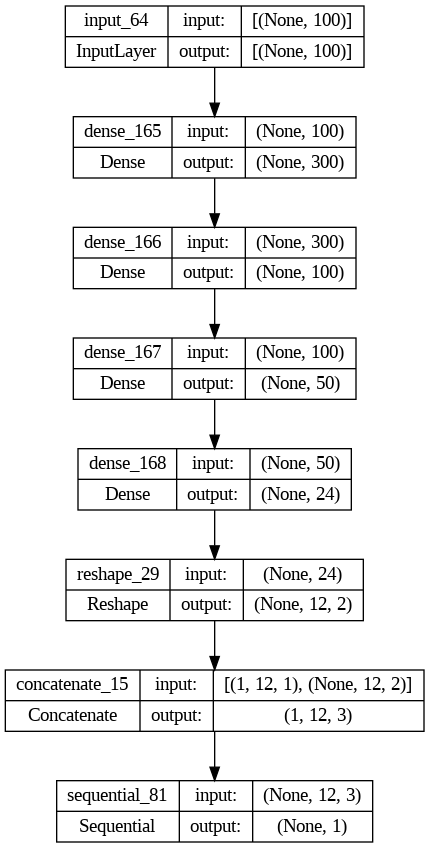

In [67]:
# plot and save your model
import tensorflow as tf
gan_model.summary()
img_file = 'model.png'
tf.keras.utils.plot_model(gan_model, to_file=img_file, show_shapes=True, show_layer_names=True)


In [68]:
generator.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_165 (Dense)           (None, 300)               30300     
                                                                 
 dense_166 (Dense)           (None, 100)               30100     
                                                                 
 dense_167 (Dense)           (None, 50)                5050      
                                                                 
 dense_168 (Dense)           (None, 24)                1224      
                                                                 
 reshape_29 (Reshape)        (None, 12, 2)             0         
                                                                 
Total params: 66,674
Trainable params: 66,674
Non-trainable params: 0
_________________________________________________________________


In [12]:
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               41200     
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 46,301
Trainable params: 0
Non-trainable params: 46,301
_________________________________________________________________


In [57]:
generator = define_generator(latent_dim)
x,y=generate_fake_samples(generator, latent_dim, 20)


In [58]:
x.shape

(20, 12, 2)

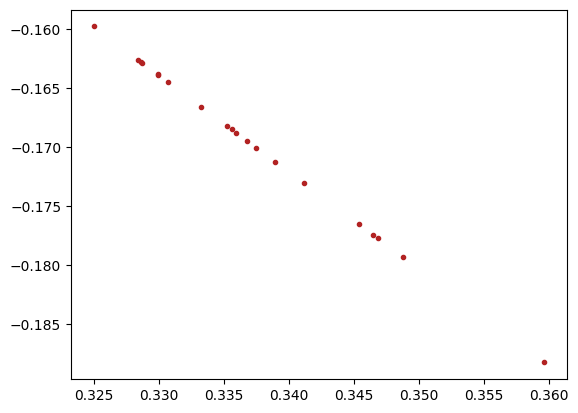

In [ ]:
pred_data=generate_fake_samples(generator,latent_dim,latent_dim)[0]
plt.plot(pred_data[:,0],pred_data[:,1],'.',label='Random Fake Sample',color='firebrick')


In [ ]:
generate_latent_points(latent_dim, n)

array([[ 0.7088612 ,  1.37253496, -0.84726362, ...,  0.4814617 ,
        -0.86111342,  0.34100038],
       [ 0.92985551,  0.51127476,  1.08520828, ...,  0.88065917,
         1.53348331, -0.64215392],
       [-0.84949204,  0.22900586,  0.61246002, ..., -0.03012969,
         0.60877503,  0.63813142],
       ...,
       [-1.03441023, -0.99259682,  0.78467267, ...,  1.07196495,
         1.26122114,  0.50098934],
       [-0.32145052, -1.40190046, -1.0057025 , ...,  0.26421188,
         1.22943472, -0.42918383],
       [-0.48487604, -0.31791122,  2.22241101, ...,  0.82256294,
         1.12801868, -0.7759051 ]])

In [ ]:

#try this demo with keras==2.2.4 and tensorflow==1.13.1:

from keras import Sequential, Model
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, concatenate
import numpy as np

model1 = Sequential()
model1.add(Embedding(20, 10, trainable=True))
model1.add(GlobalAveragePooling1D())
model1.add(Dense(1, activation='sigmoid'))
model2 = Sequential()
model2.add(Embedding(20, 10, trainable=True))
model2.add(GlobalAveragePooling1D())
model2.add(Dense(1, activation='sigmoid'))

model_concat = concatenate([model1.output, model2.output], axis=-1)
model_concat = Dense(1, activation='softmax')(model_concat)
model = Model(inputs=[model1.input, model2.input], outputs=model_concat)

model.compile(loss='binary_crossentropy', optimizer='adam')

X_train_1 = np.random.randint(0, 20, (10000, 256))
X_train_2 = np.random.randint(0, 20, (10000, 256))
Y_train = np.random.randint(0, 2, 10000)

model.fit([X_train_1, X_train_2], Y_train, batch_size=1000, epochs=200,
              verbose=True)